Bilayer unit domain. Sigma optimisation

In [1]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
    dx,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, meshtags
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix, assemble_scalar
import basix
from dolfinx.geometry import bb_tree
from dolfinx import geometry
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  

Domain, PML, refinement and physical configurations

In [2]:
# Define element size for the mesh refinement
h_i = [0.125/2,   # N=1
       0.125/4,   # N=2
       0.125/8,] # N=3
N_i=[1,2,3]


# Domain configuration
Lx = 1. # fluid domain length (without PML)
l_inner=Lx/2

# Physical configuration
rho_media_1 = 1. # kg/m^3 
vel_media_1 = 2.   # m/s
rho_media_2 = 1. # kg/m^3 
vel_media_2 = 1.   # m/s

# Define the density and velocity functions  
def rho_function(x):    
    return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

def vel_function(x):    
    return np.where(x[0] > l_inner, vel_media_2,vel_media_1)

# PML configuration
pml_thickness = Lx/8

# Solver configuration
requested_eigenvalues_number = 30 # Number of eigenvalues to compute

degree=[2,1]  # Polynomial degree for pressure and velocity
sigma_sweep_quadratic=np.linspace(10., 200., 10)
target=[-12.56j, 
        -50.26j] # Shifts for the eigensolvers

Solver configuration and computing

In [3]:
def get_configured_problem(mesh, degrees, sigma_x, target):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Identify the fluid cells
    # fluid_cells = locate_entities(mesh, tdim, lambda x: x[0] <= Lx)

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 
    
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 

    # Define differential operators
    dx = Measure("dx", domain=mesh)

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 2))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q) 
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx, -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(target)  
    solver.solve()
    n_eigs_converged_quadratic = solver.getConverged()

    return solver, mesh, Q, V, dof

In [4]:
def assign_eigenvector_to_functions(vrA, p_h, v_h, dof):
    """
    Reparte o vector eigenvector 'vrA' entre p_h e v_h
    e normaliza no punto 'normalize_at'.
    """

    # --- separar as partes do autovector ---
    p_vals = vrA[:dof["p"]]
    v_vals = vrA[dof["p"]:]

    # asignar
    p_h.x.array[:] = p_vals
    v_h.x.array[:] = v_vals

    return p_h, v_h

In [5]:
def get_exact_eigenpair(selected_index, Q, V, x_hat, sigma_x, gamma_x):
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    w=exact_physical_eigs_function(selected_index)

    p_1 = lambda x: np.sin(w * x[0] / vel_media_1)
    p_2 = lambda x: -np.sin(-w * l_inner / vel_media_1) * np.exp(1j * w / vel_media_2 * (x_hat(x,w) - l_inner))
    p = lambda x: np.where(x[0] > l_inner, p_2(x), p_1(x))

    sigma_x_function_cond= lambda x: np.where(x[0]<=Lx, x[0]*0., sigma_x(x))

    v_1=lambda x: 1/(-1j*w)*(w / vel_media_1) * np.cos(w * x[0] / vel_media_1)
    v_2 = (lambda x: 1/(-1j*w+sigma_x_function_cond(x)*rho_media_1)* -np.sin(-w * l_inner / vel_media_1) *(1j * w / vel_media_2)
        * np.exp(1j * w / vel_media_2 * (x_hat(x,w) - l_inner))* gamma_x(x, w)[0])
    v = lambda x: np.where(x[0] > l_inner, v_2(x), v_1(x))

    p_ex = Function(Q, name="p_ex")
    p_ex.interpolate(p)

    v_ex = Function(V, name="v_ex")
    v_ex.interpolate(v)

    return [w, p_ex, v_ex]

In [6]:
def project_exact_to_mesh(u_exact, Vh):
    """
    Proxecta/interpola unha expresión exacta (UFL) ou un Function
    doutra malla ao espazo funcional Vh (malla actual).

    Funciona en dolfinx 0.9 e evita todos os problemas de dimensión
    e de Expression nos MixedElements.
    """

    # Se u_exact xa é un Function no mesmo espazo, devolver directamente
    if isinstance(u_exact, Function) and u_exact.function_space == Vh:
        return u_exact

    # Crear Function sobre Vh
    u_proj = Function(Vh)

    # Caso 1: exacta é Function doutra malla -> interpolar
    if isinstance(u_exact, Function):
        u_proj.interpolate(u_exact)
        return u_proj

    # Caso 2: exacta é UFL Expression -> interpolar mediante Expression
    # Obter puntos de interpolación (DOF coordinates)
    X = Vh.tabulate_dof_coordinates()

    # Se é 1D pero X ven con máis dimensións, quedar coa primeira columna
    if X.ndim == 2 and X.shape[1] > 1:
        X = X[:, :1]

    expr = Expression(u_exact, X, dtype=u_proj.x.array.dtype)
    u_proj.interpolate(expr)

    return u_proj


In [7]:
def eigenvector_L2_error_physical(u_num, u_exact, Lx, mesh):
    """
    Erro relativo L2 só no dominio físico [0, Lx] en DOLFINx 0.9.
    Alinea fase/signo antes de medir o erro.
    """

    import numpy as np
    import ufl
    from ufl import inner
    from dolfinx.mesh import locate_entities, meshtags
    from dolfinx.fem import form, assemble_scalar

    
    tdim = mesh.topology.dim

    # --- 1) Localizar celas físicas ---
    cells_phys = locate_entities(
        mesh, tdim,
        lambda x: np.logical_and(x[0] >= 0, x[0] < Lx)
    )

    if len(cells_phys) == 0:
        raise RuntimeError("Non se detectaron celas na rexión física [0, Lx].")

    # Asignar etiqueta 1
    values = np.full(len(cells_phys), 1, dtype=np.int32)
    mt = meshtags(mesh, tdim, cells_phys, values)

    # Medida restrinxida
    dx_phys = ufl.Measure("dx", domain=mesh, subdomain_data=mt)
    
    # --- 3) Norma L2 do erro no dominio físico ---
    diff = u_num - u_exact

    num = np.sqrt(assemble_scalar(form(inner(diff, diff) * dx_phys(1))))
    den = np.sqrt(assemble_scalar(form(inner(u_exact, u_exact) * dx_phys(1))))

    return num / den


In [8]:
def eval_point_fast(u, bb, x, mesh):
    pt = np.array([x, 0.0, 0.0], dtype=np.float64)

    # 1) Buscamos celas candidatas no árbol
    candidates = geometry.compute_collisions_points(bb, pt)

    # 2) Filtramos celas que realmente conteñen o punto
    cell = geometry.compute_colliding_cells(mesh, candidates, pt)

    if len(cell) == 0:
        return np.nan

    # 3) Avaliar a función FEM
    P = np.array([pt])
    C = np.array([cell.array[0]], dtype=np.int32)

    val = u.eval(P, C)
    return val[0]

In [9]:
def normalize_at_Lx(u, bb, Lx, mesh):
    val_Lx = eval_point_fast(u, bb, Lx, mesh)
    u.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
    return u

In [10]:
def get_closest_approx_eigenpair(exact_eigenvalue_idx, solver, Q, V, dof, sigma_i, mesh, verbose=False, plot=False):
    """
    Devuelve el autovalor y autovector más cercano a omega_target
    usando distancia compleja |λ - λ_target|, sin usar get_approx_eigenpair.

    Returns
    -------
    lambda_best : complex
    x_best : PETSc.Vec (copia del autovector)
    idx_best : int (índice raw en solver)
    p_h:    Function
    v_h: Function
    """
    p_exact = [None] * 5  # Almacena los autovectores exactos de presión
    v_exact = [None] * 5  # Almacena los autovectores exactos de velocidad
    p_approx = [None] * 5  # Almacena los autovectores exactos de presión
    v_approx = [None] * 5  # Almacena los autovectores exactos de velocidad
    best = None
    best_3 = None

    # Vector temporal para extraer Eigenpairs
    p_h = Function(Q, name="p_h")
    v_h = Function(V, name="v_h")

    # Número de modos convergidos
    nconv = solver.getConverged()
    if nconv == 0:
        raise RuntimeError("No hay autovalores convergidos")

    # Vector temporal para extraer Eigenpairs
    vrA, vi = solver.getOperators()[0].getVecs()

    x_hat_quadratic=lambda x, w: (x[0]+ (np.abs(x[0]) >= Lx)* np.sign(x[0])* 1j/ w* sigma_i* (np.abs(x[0]) - Lx) ** 3/ (3 * pml_thickness**2))
    sigma_quadratic_py=lambda x: (np.abs(x[0]) >= Lx) * sigma_i * (np.abs(x[0]) - Lx) ** 2 / (pml_thickness ** 2)
    gamma_x_quadratic = lambda x, w: 1.0 + (np.abs(x[0]) >= Lx) * 1j / w * sigma_i * (np.abs(x[0]) - Lx) ** 2 / (pml_thickness ** 2)

    [exact_eigenvalue, p_exact, v_exact] =   get_exact_eigenpair(exact_eigenvalue_idx, Q, V, x_hat_quadratic, sigma_quadratic_py, gamma_x_quadratic)

    bb = bb_tree(mesh, mesh.topology.dim)
    for k in range(nconv):
        approx_eigenvalue = solver.getEigenvalue(k) * 1j 
        solver.getEigenpair(k, vrA)  
        # Vector temporal para extraer Eigenpairs
        p_h = Function(Q, name="p_h")
        v_h = Function(V, name="v_h")
        [p_h, v_h]=assign_eigenvector_to_functions(vrA = vrA, p_h = p_h, v_h = v_h, dof = dof)

        # --- autovalores ---
        err_eig = abs(approx_eigenvalue - exact_eigenvalue) / abs(exact_eigenvalue)

        # --- autovectores ---

        p_h=normalize_at_Lx(p_h, bb, Lx, mesh)
        v_h=normalize_at_Lx(v_h, bb, Lx, mesh)
        p_exact=normalize_at_Lx(p_exact, bb, Lx, mesh)
        v_exact=normalize_at_Lx(v_exact, bb, Lx, mesh)


        # Errores L2 en dominio físico
        err_p = eigenvector_L2_error_physical(p_h, p_exact, Lx, mesh)
        err_v = eigenvector_L2_error_physical(v_h, v_exact, Lx, mesh)

        # Total
        err = err_eig + err_p + err_v   
        

        if best is None or err < best[2]:
            best = (approx_eigenvalue, k, err,err_eig, err_p, err_v)

    closest_eig, idx_best, rel_err_total, rel_err_eig_best, rel_err_p_best, rel_err_v_best = best

    # Vector temporal para extraer Eigenpairs
    p_h = Function(Q, name="p_h")
    v_h = Function(V, name="v_h")
    vrA, vi = solver.getOperators()[0].getVecs()
    solver.getEigenpair(idx_best, vrA)
    [p_approx, v_approx]=assign_eigenvector_to_functions(vrA = vrA, p_h = p_h, v_h = v_h, dof = dof)

    if verbose:
        print(f"$\sigma_i={sigma_i}$")
        print(f"$[Closest to \omega={exact_eigenvalue}] idx={idx_best}  \omega={closest_eig}  \epsilon_r={rel_err_eig_best+rel_err_p_best+rel_err_v_best} \epsilon_r(\omega)={rel_err_eig_best}  \epsilon_r(p)={rel_err_p_best} \epsilon_r(v)={rel_err_v_best}$")


    if plot:
        from dolfinx import geometry

        fig, axes = plt.subplots(1, 2, figsize=(12,8))

        # ============================================================
        #  FILA 1 — AUTOVECTORES p
        # ============================================================

        # --- p, modo 0 ---
        ax = axes[0]
        

        val_Lx = eval_point_fast(p_approx, bb, Lx, mesh)
        p_approx.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
        val_Lx = eval_point_fast(p_exact, bb, Lx, mesh)
        p_exact.x.array[:] /= val_Lx
        xx = np.linspace(0, Lx+pml_thickness, 2000)
        yy = [eval_point_fast(p_approx, bb, x, mesh) for x in xx]
        ax.plot(xx, np.real(yy), label="Re(p)", linestyle="-.")
        yy = [eval_point_fast(p_exact, bb, x, mesh) for x in xx]
        ax.plot(xx, np.real(yy), label="Re(p)", linestyle="-")
        ax.set_xlabel("x [m]")
        ax.set_ylabel("p(x) [Pa]")
        ax.set_title("Modo {} con sigma quadratic".format(0))
        ax.grid(True)


        ax = axes[1]
        val_Lx = eval_point_fast(v_approx, bb, Lx, mesh)
        v_approx.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
        val_Lx = eval_point_fast(v_exact, bb, Lx, mesh)
        v_exact.x.array[:] /= val_Lx
        xx = np.linspace(0, Lx+pml_thickness, 2000)
        yy = [eval_point_fast(v_approx, bb, x, mesh) for x in xx]
        ax.plot(xx, np.real(yy), label="Re(v)", linestyle="-.")
        yy = [eval_point_fast(v_exact, bb, x, mesh) for x in xx]
        ax.plot(xx, np.real(yy), label="Re(v)", linestyle="-")        
        ax.set_xlabel("x [m]")
        ax.set_ylabel("v(x) ")
        ax.grid(True)

        plt.show()

    return closest_eig, p_approx, v_approx, rel_err_eig_best, rel_err_p_best, rel_err_v_best


In [11]:
# Diccionarios onde gardar os erros para cada refinamento N
rel_err_eig_sigma_sweep = {0: {}, 3: {}}   # erros para modo 0 e 3
rel_err_p_sigma_sweep = {0: {}, 3: {}}   # erros para modo 0 e 3
rel_err_v_sigma_sweep = {0: {}, 3: {}}   # erros para modo 0 e 3
rel_err_total_sigma_sweep = {0: {}, 3: {}}   # erros para modo 0 e 3

approx_omega  = {0: {}, 3: {}}
approx_p      = {0: {}, 3: {}}
approx_v      = {0: {}, 3: {}}

# Iterar sobre N = 0,1,2 → corresponde a h_i[0], h_i[1], h_i[2]
for N, h in enumerate(h_i):

    print(f"\n=== Executando para N = {N+2}, h = {h} ===")

    # Inicializar listas baleiras para este N
    rel_err_eig_sigma_sweep[0][N] = []
    rel_err_eig_sigma_sweep[3][N] = []
    rel_err_p_sigma_sweep[0][N] = []
    rel_err_p_sigma_sweep[3][N] = []
    rel_err_v_sigma_sweep[0][N] = []
    rel_err_v_sigma_sweep[3][N] = []
    rel_err_total_sigma_sweep[0][N] = []
    rel_err_total_sigma_sweep[3][N] = []
    

    approx_omega[0][N] = []
    approx_omega[3][N] = []

    approx_p[0][N] = []
    approx_p[3][N] = []

    approx_v[0][N] = []
    approx_v[3][N] = []

    # Crear nova malla para este refinamento
    mesh = create_interval(
        MPI.COMM_WORLD,
        int((Lx + pml_thickness) / h),
        [0, Lx + pml_thickness]
    )

    # Percorrer sigma_sweep_quadratic
    for i, sigma_i in enumerate(sigma_sweep_quadratic):

        sigma_quadratic_ufl =lambda x: conditional(x[0] > Lx, sigma_i*(x[0]-Lx)**2/(pml_thickness**2), 0.0)
        solver_target_0, mesh, Q_, V_, dof_ = get_configured_problem(mesh, degree, sigma_quadratic_ufl, target[0])
        solver_target_3, mesh, Q_, V_, dof_ = get_configured_problem(mesh, degree, sigma_quadratic_ufl, target[1])
        (eig0, p0, v0, err0_eig, err0_p, err0_v) = get_closest_approx_eigenpair(1, solver_target_0, Q_, V_, dof_, sigma_i, mesh,verbose=True, plot=False)
        (eig3, p3, v3, err3_eig, err3_p, err3_v) = get_closest_approx_eigenpair(4, solver_target_3, Q_, V_, dof_, sigma_i, mesh,verbose=True, plot=False)

        err0 = err0_eig + err0_p + err0_v
        err3 = err3_eig + err3_p + err3_v
        # Gardar resultados
        approx_omega[0][N].append(eig0)
        approx_omega[3][N].append(eig3)

        approx_p[0][N].append(p0)
        approx_p[3][N].append(p3)

        approx_v[0][N].append(v0)
        approx_v[3][N].append(v3)

        rel_err_eig_sigma_sweep[0][N].append(err0_eig)
        rel_err_eig_sigma_sweep[3][N].append(err3_eig)

        rel_err_p_sigma_sweep[0][N].append(err0_p)
        rel_err_p_sigma_sweep[3][N].append(err3_p)

        rel_err_v_sigma_sweep[0][N].append(err0_v)
        rel_err_v_sigma_sweep[3][N].append(err3_v)

        rel_err_total_sigma_sweep[0][N].append(err0)
        rel_err_total_sigma_sweep[3][N].append(err3)



=== Executando para N = 2, h = 0.0625 ===
$\sigma_i=10.0$
$[Closest to \omega=(12.566370614359172-2.197224577336219j)] idx=3  \omega=(18.041152479217423-0.5744611983614942j)  \epsilon_r=(4.230943974548382+0j) \epsilon_r(\omega)=0.4476139661767476  \epsilon_r(p)=(2.0833000823973116+0j) \epsilon_r(v)=(1.7000299259743232+0j)$
$\sigma_i=10.0$
$[Closest to \omega=(50.26548245743669-2.197224577336219j)] idx=32  \omega=(115.04206697835272-0.23170498737797363j)  \epsilon_r=(4.061380875199796+0j) \epsilon_r(\omega)=1.2880523144211524  \epsilon_r(p)=(1.2038675144627369+0j) \epsilon_r(v)=(1.5694610463159064+0j)$
$\sigma_i=31.11111111111111$
$[Closest to \omega=(12.566370614359172-2.197224577336219j)] idx=1  \omega=(13.895968188900978-1.3811904115511622j)  \epsilon_r=(1.8346888874092544+0j) \epsilon_r(\omega)=0.12228920140602767  \epsilon_r(p)=(0.9250843292006207+0j) \epsilon_r(v)=(0.787315356802606+0j)$
$\sigma_i=31.11111111111111$
$[Closest to \omega=(50.26548245743669-2.197224577336219j)] idx=

KeyboardInterrupt: 

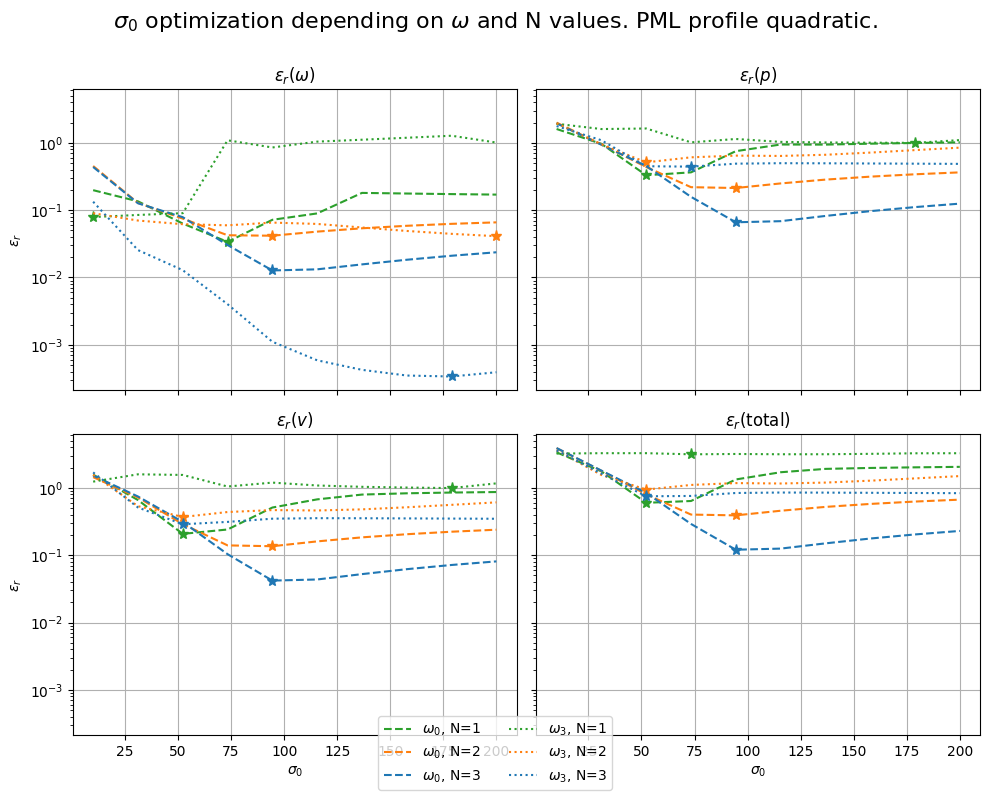

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

colors = ['tab:green', 'tab:orange', 'tab:blue']
linestyles = {0: '--', 3: ':'}
labels = {0: r'$\omega_0$', 3: r'$\omega_3$'}

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

err_dict = {
    'eig': rel_err_eig_sigma_sweep,
    'p':   rel_err_p_sigma_sweep,
    'v':   rel_err_v_sigma_sweep,
    'tot': rel_err_total_sigma_sweep
}

titles = {
    'eig': r'$\epsilon_r(\omega)$',
    'p':   r'$\epsilon_r(p)$',
    'v':   r'$\epsilon_r(v)$',
    'tot': r'$\epsilon_r(\mathrm{total})$'
}

for ax, key in zip(axes.flat, err_dict):
    for j in [0, 3]:                  # modos físicos
        for N_index in range(len(N_i)):
            plot_N = N_index + 1
            col = colors[N_index]
            ls = linestyles[j]

            errs = err_dict[key][j][N_index]

            ax.plot(
                sigma_sweep_quadratic,
                errs,
                color=col,
                linestyle=ls,
                label=f"{labels[j]}, N={plot_N}"
            )

            # mínimo
            k = np.argmin(errs)
            ax.plot(
                sigma_sweep_quadratic[k],
                errs[k],
                '*',
                color=col,
                markersize=8
            )

    ax.set_title(titles[key])
    ax.set_yscale('log')
    ax.grid(True)

# etiquetas comunes
for ax in axes[-1, :]:
    ax.set_xlabel(r'$\sigma_0$')

for ax in axes[:, 0]:
    ax.set_ylabel(r'$\epsilon_r$')

# leyenda única
handles, labels_leg = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels_leg, ncol=2, loc='lower center')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.suptitle('$\sigma_0$ optimization depending on $\omega$ and N values. PML profile quadratic.', fontsize=16)
plt.savefig("sigma_optimization_quadratic.png", dpi=300)
plt.show()


3
Sigma of interest:  73.33333333333333
Relative error total:  (0.40160262708988304+0j)


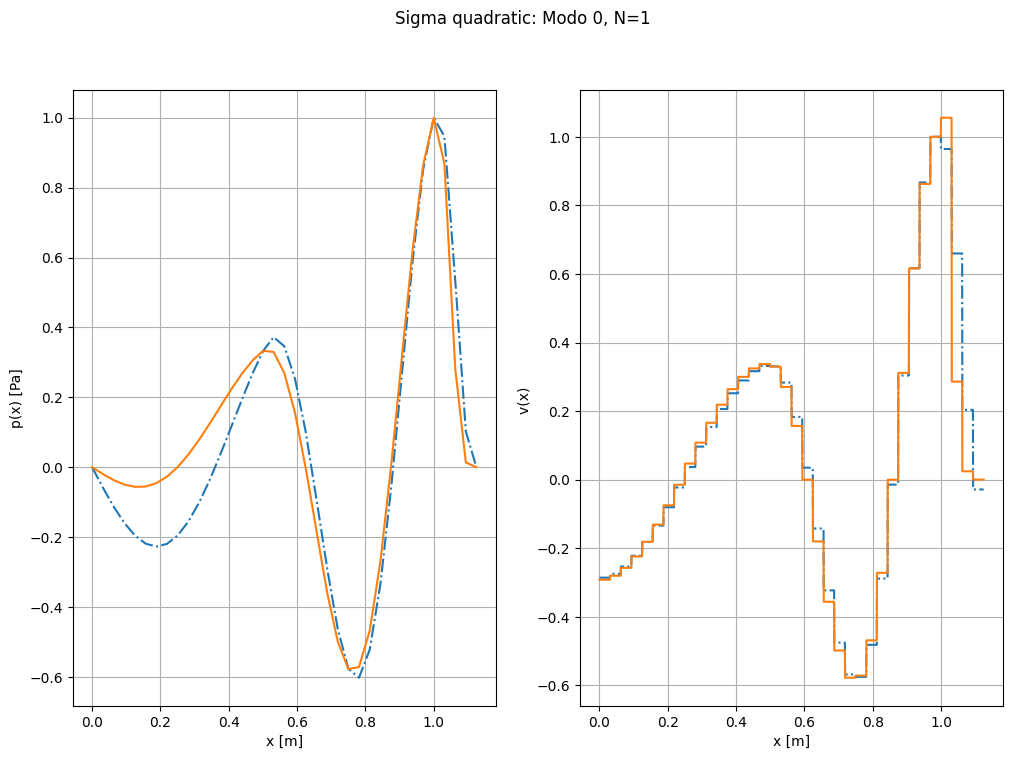

In [ ]:
eig_number=0  # modo físico 0
N=1         # refinamento N=4 (0,1,2 → 2,3,4)

sigma_of_interest=72
indice = np.argmin(np.abs(sigma_sweep_quadratic - sigma_of_interest))
print(indice)
print("Sigma of interest: ", sigma_sweep_quadratic[indice])
print("Relative error total: ", rel_err_total_sigma_sweep[eig_number][N][indice])

idx_min_err = np.argmin(rel_err_total_sigma_sweep[eig_number][N])
p_approx = approx_p[eig_number][N][indice]
v_approx = approx_v[eig_number][N][indice]

mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness) / h_i[N]), [0, Lx + pml_thickness])

bb = bb_tree(mesh, mesh.topology.dim)

x_hat_quadratic=lambda x, w: (x[0]+ (np.abs(x[0]) >= Lx)* np.sign(x[0])* 1j/ w* sigma_i* (np.abs(x[0]) - Lx) ** 3/ (3 * pml_thickness**2))
sigma_quadratic_py=lambda x: (np.abs(x[0]) >= Lx) * sigma_i * (np.abs(x[0]) - Lx) ** 2 / (pml_thickness ** 2)
gamma_x_quadratic = lambda x, w: 1.0 + (np.abs(x[0]) >= Lx) * 1j / w * sigma_i * (np.abs(x[0]) - Lx) ** 2 / (pml_thickness ** 2)

# Extract FunctionSpace objects from the approximated functions
Q = p_approx.ufl_function_space()
V = v_approx.ufl_function_space()
[exact_eigenvalue, p_exact, v_exact] =   get_exact_eigenpair(eig_number+1, Q, V, x_hat_quadratic, sigma_quadratic_py, gamma_x_quadratic)

fig, axes = plt.subplots(1, 2, figsize=(12,8))
# --- p, modo 0 ---
ax = axes[0]
val_Lx = eval_point_fast(p_approx, bb, Lx, mesh)
p_approx.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
val_Lx = eval_point_fast(p_exact, bb, Lx, mesh)
p_exact.x.array[:] /= val_Lx
xx = np.linspace(0, Lx+pml_thickness, 2000)
yy = [eval_point_fast(p_approx, bb, x, mesh) for x in xx]
ax.plot(xx, np.real(yy), label="Re(p)", linestyle="-.")
yy = [eval_point_fast(p_exact, bb, x, mesh) for x in xx]
ax.plot(xx, np.real(yy), label="Re(p)", linestyle="-")
ax.set_xlabel("x [m]")
ax.set_ylabel("p(x) [Pa]")
ax.grid(True)


ax = axes[1]
val_Lx = eval_point_fast(v_approx, bb, Lx, mesh)
v_approx.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
val_Lx = eval_point_fast(v_exact, bb, Lx, mesh)
v_exact.x.array[:] /= val_Lx
xx = np.linspace(0, Lx+pml_thickness, 2000)
yy = [eval_point_fast(v_approx, bb, x, mesh) for x in xx]
ax.plot(xx, np.real(yy), label="Re(v)", linestyle="-.")
yy = [eval_point_fast(v_exact, bb, x, mesh) for x in xx]
ax.plot(xx, np.real(yy), label="Re(v)", linestyle="-")        
ax.set_xlabel("x [m]")
ax.set_ylabel("v(x) ")
ax.grid(True)
fig.suptitle("Sigma quadratic: Modo {eig}, N={N}".format(eig=eig_number, N=N))
plt.show()


Approx eigenvalue idx  0 :  (53.6075737621802-0.05627051010040712j)


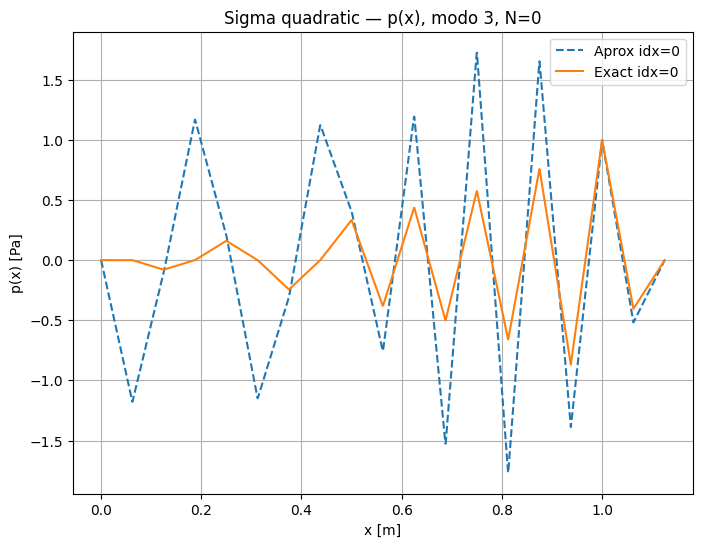

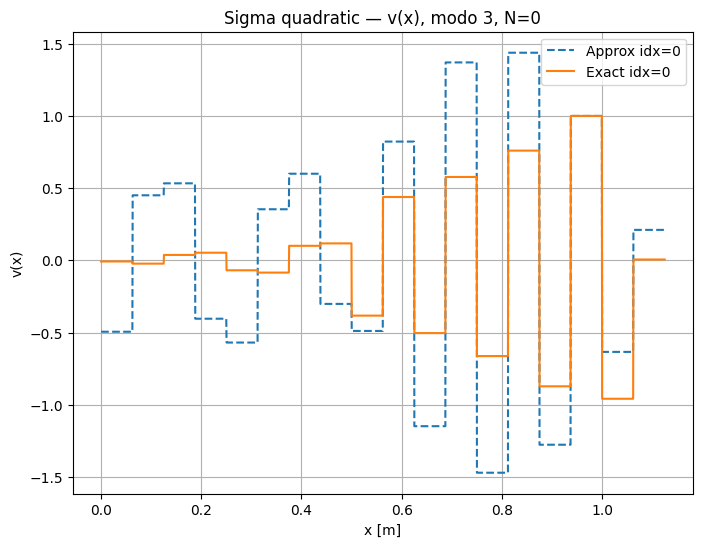

In [ ]:
eig_number = 3
N = 0
indices = [0] #, 1, 2, 3]

mesh = create_interval(
    MPI.COMM_WORLD,
    int((Lx + pml_thickness) / h_i[N]),
    [0, Lx + pml_thickness]
)
bb = bb_tree(mesh, mesh.topology.dim)

x_hat_quadratic = lambda x, w: (
    x[0]
    + (np.abs(x[0]) >= Lx)
    * np.sign(x[0])
    * 1j / w
    * sigma_i
    * (np.abs(x[0]) - Lx) ** 3
    / (3 * pml_thickness**2)
)
sigma_quadratic_py = lambda x: (
    (np.abs(x[0]) >= Lx)
    * sigma_i
    * (np.abs(x[0]) - Lx) ** 2
    / (pml_thickness**2)
)
gamma_x_quadratic = lambda x, w: (
    1.0
    + (np.abs(x[0]) >= Lx)
    * 1j / w
    * sigma_i
    * (np.abs(x[0]) - Lx) ** 2
    / (pml_thickness**2)
)

xx = np.linspace(0, Lx + pml_thickness, 2000)

# =======================
#        PLOT p
# =======================
plt.figure(figsize=(8, 6))

for idx in indices:
    p_approx = approx_p[eig_number][N][idx]
    v_approx = approx_v[eig_number][N][idx]
    print("Approx eigenvalue idx ", idx, ": ", approx_omega[eig_number][N][idx])
    Q = p_approx.ufl_function_space()
    V = v_approx.ufl_function_space()

    _, p_exact, _ = get_exact_eigenpair(
        eig_number + 1, Q, V,
        x_hat_quadratic, sigma_quadratic_py, gamma_x_quadratic
    )

    # normalización en x = Lx
    p_approx.x.array[:] /= eval_point_fast(p_approx, bb, Lx, mesh)
    p_exact.x.array[:]  /= eval_point_fast(p_exact,  bb, Lx, mesh)

    yy_ap = [eval_point_fast(p_approx, bb, x, mesh) for x in xx]
    yy_ex = [eval_point_fast(p_exact,  bb, x, mesh) for x in xx]

    plt.plot(xx, np.real(yy_ap), "--", label=f"Aprox idx={idx}")
plt.plot(xx, np.real(yy_ex), "-",  label=f"Exact idx={idx}")

plt.xlabel("x [m]")
plt.ylabel("p(x) [Pa]")
plt.grid(True)
plt.legend()
plt.title(f"Sigma quadratic — p(x), modo {eig_number}, N={N}")
plt.show()

# =======================
#        PLOT v
# =======================
plt.figure(figsize=(8, 6))

for idx in indices:
    p_approx = approx_p[eig_number][N][idx]
    v_approx = approx_v[eig_number][N][idx]

    Q = p_approx.ufl_function_space()
    V = v_approx.ufl_function_space()

    _, _, v_exact = get_exact_eigenpair(
        eig_number + 1, Q, V,
        x_hat_quadratic, sigma_quadratic_py, gamma_x_quadratic
    )

    # normalización en x = Lx
    v_approx.x.array[:] /= eval_point_fast(v_approx, bb, Lx, mesh)
    v_exact.x.array[:]  /= eval_point_fast(v_exact,  bb, Lx, mesh)

    yy_ap = [eval_point_fast(v_approx, bb, x, mesh) for x in xx]
    yy_ex = [eval_point_fast(v_exact,  bb, x, mesh) for x in xx]

    plt.plot(xx, np.real(yy_ap), "--", label=f"Approx idx={idx}")
plt.plot(xx, np.real(yy_ex), "-",  label=f"Exact idx={idx}")

plt.xlabel("x [m]")
plt.ylabel("v(x)")
plt.grid(True)
plt.legend()
plt.title(f"Sigma quadratic — v(x), modo {eig_number}, N={N}")
plt.show()


In [ ]:
from scipy.io import savemat

savemat(
    "results_sigma_optimization_quadratic.mat",
    {
        "pml_thickness": pml_thickness,
        "Lx": Lx,
        "l_inner": l_inner,
        "rho_media1": rho_media_1,
        "rho_media_2": rho_media_2,
        "vel_media_1": vel_media_1,
        "vel_media_2": vel_media_2,
        "sigma_sweep": sigma_sweep_quadratic,
        "rel err eig": rel_err_eig_sigma_sweep,
        "rel error p": rel_err_p_sigma_sweep,
        "rel error v": rel_err_v_sigma_sweep,
        "rel error total": rel_err_total_sigma_sweep,
        "approx_p": approx_p,
        "approx_v": approx_v,
        "approx_omega": approx_omega,
        "sigma_quadratic_ufl": sigma_quadratic_ufl,
        "target": target,
    }
)
